In [49]:
# Import dependancies
import tweepy
import re
import requests
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import pickle
import time
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import nltk
import ast
import community
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter

The user_id column has to be read as a str:

In [2]:
# Load data
usernames_uk = pd.read_csv("data_w_usernames_UK.csv",index_col=0, dtype={'user_id':str})

C:\Users\difra\AppData\Local\Temp\ipykernel_30608\1176245279.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv("data_w_usernames_UK.csv",index_col=0, dtype={'user_id':str})


In [6]:
usernames_uk = data_df.reset_index(drop = True)

In [25]:
mentions = pd.read_csv("mentions.csv", index_col = 0)
mentions = mentions.reset_index(drop=True)

Merging the dataframe that contains only the twitter with at least one mention with the dataframe that contained the scraped usernames

In [44]:
mentions['username'] = pd.merge(mentions, usernames_uk, on = "tweet_ID").iloc[:, -1] 

In [45]:
data_df = mentions

In [46]:
data_df

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,tweet,len_content,mentions,username
0,1234294853330182144,20973388,covid,2020-03-02 01:49:59,0.406,0.613,0.458,0.271,0.460,-1.0,F,"The UK government is considering all options, ...",27.0,['darrenadam'],hoglet3
1,1234305116506861568,442831126,covid,2020-03-02 02:30:46,0.665,0.326,0.373,0.443,0.325,1.0,H,@Grummz An article for you after yesterday's m...,18.0,['Grummz'],Dunnn85
2,1234310189404348417,1157949934949347328,wuhan,2020-03-02 02:50:56,0.371,0.525,0.426,0.234,0.455,-1.0,F,@fascinatorfun So question is why the mortalit...,14.0,['fascinatorfun'],thevicarswife
3,1234318241431990272,16027848,covid,2020-03-02 03:22:55,0.329,0.587,0.570,0.138,0.474,-1.0,F,Video: #ToxicTories try to hide damage to NHS ...,27.0,['skwawkbox'],flangeworthy
4,1234321940401270785,282914879,covid,2020-03-02 03:37:37,0.514,0.364,0.370,0.361,0.360,0.0,NaN,"@dray24574721 @BNODesk This, from S Korea afte...",15.0,"['dray24574721', 'BNODesk']",WTS_Software
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271091,1285835534766673923,916192094330507264,covid,2020-07-22 07:14:15,0.629,0.306,0.315,0.454,0.285,1.0,H,#Reboot weekends have started up again. #covi...,24.0,['actressann'],NaN
271092,1285835650059636736,3057049653,covid,2020-07-22 07:14:43,0.440,0.399,0.464,0.245,0.436,-1.0,A,@Gnomeponders My daughter and partner are both...,20.0,['Gnomeponders'],NaN
271093,1285835723740856321,216650916,covid,2020-07-22 07:15:00,0.598,0.336,0.330,0.406,0.318,1.0,H,Join on September 1st @ 5pm for a HealthChat w...,41.0,['RoyLilley'],NaN
271094,1285835987424337921,75508547,corona,2020-07-22 07:16:03,0.250,0.507,0.608,0.141,0.508,-2.0,A,@sidudeja But why would you want anyone dead? ...,24.0,['sidudeja'],NaN


Removing the rows for which it was not possible to retrieve the usernames:

In [57]:
data_df = data_df.dropna(subset='username').reset_index(drop=True)

In [58]:
data_df

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,tweet,len_content,mentions,username
0,1234294853330182144,20973388,covid,2020-03-02 01:49:59,0.406,0.613,0.458,0.271,0.460,-1.0,F,"The UK government is considering all options, ...",27.0,[darrenadam],hoglet3
1,1234305116506861568,442831126,covid,2020-03-02 02:30:46,0.665,0.326,0.373,0.443,0.325,1.0,H,@Grummz An article for you after yesterday's m...,18.0,[Grummz],Dunnn85
2,1234310189404348417,1157949934949347328,wuhan,2020-03-02 02:50:56,0.371,0.525,0.426,0.234,0.455,-1.0,F,@fascinatorfun So question is why the mortalit...,14.0,[fascinatorfun],thevicarswife
3,1234318241431990272,16027848,covid,2020-03-02 03:22:55,0.329,0.587,0.570,0.138,0.474,-1.0,F,Video: #ToxicTories try to hide damage to NHS ...,27.0,[skwawkbox],flangeworthy
4,1234321940401270785,282914879,covid,2020-03-02 03:37:37,0.514,0.364,0.370,0.361,0.360,0.0,NaN,"@dray24574721 @BNODesk This, from S Korea afte...",15.0,"[dray24574721, BNODesk]",WTS_Software
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114228,1254368939859226626,949341250485915648,covid,2020-04-26 11:17:14,0.438,0.482,0.472,0.319,0.380,-1.0,F,@RotoBrits @rototrix @JustinMasonFWFB Have too...,13.0,"[RotoBrits, rototrix, JustinMasonFWFB]",ahron82
114229,1254369023875264512,547087953,covid,2020-04-26 11:17:34,0.585,0.301,0.386,0.393,0.299,1.0,H,Very important article by the former artistic ...,30.0,[battersea_arts],PayPlan
114230,1254369134915334145,1143466752220831745,covid,2020-04-26 11:18:01,0.555,0.410,0.364,0.332,0.337,1.0,H,COVID-19 Pandemic Shows How Important Energy E...,16.0,[EPonline],m_cuccovillo
114231,1254369187956428800,246428646,covid,2020-04-26 11:18:14,0.441,0.481,0.435,0.319,0.493,-1.0,S,@MarkSharon_DP ...air pollution-related diseas...,43.0,[MarkSharon_DP],opus_llp


To read each list in the column 'mentions' as a list and not as a str:

In [59]:
data_df['mentions'] = data_df['mentions'].apply(ast.literal_eval)

ValueError: malformed node or string: ['darrenadam']

# Network

In [62]:
dict_edges = dict(zip(data_df['username'], data_df['mentions']))

In [63]:
g = nx.DiGraph(dict_edges)

In [67]:
len(g.edges)

130545

In [68]:
len(g.nodes)

142607

In [69]:
in_degree_tuples = g.in_degree(g.nodes())
in_degree = [x[1] for x in in_degree_tuples] 

In [70]:
out_degree_tuples = g.out_degree(g.nodes())
out_degree = [x[1] for x in out_degree_tuples] 

Comparison of in-degree and out-degree distributions. The in-degree distribution has been zoomed to make it clear that for most of the users the in-degree is similar to the out degree except for some outliers that have very large in-degree because probably they are famous accounts such as news account or popular people (politicians or influencers) or famous organizations.

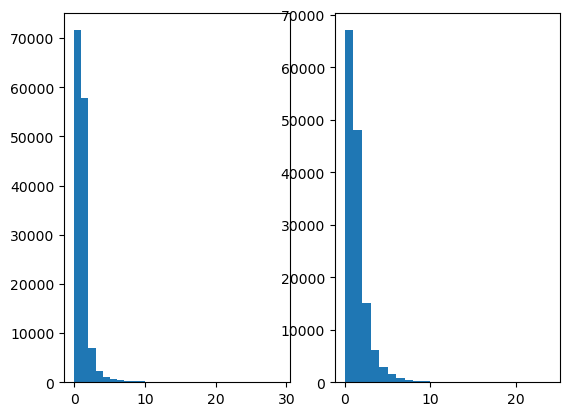

In [82]:
fig, axes = plt.subplots(1, 2)

axes[0].hist(in_degree, bins = np.arange(np.min(in_degree), 30))
axes[1].hist(out_degree, bins = np.arange(np.min(out_degree), np.max(out_degree)+2))

plt.show()

In-degree distribution plotted using a log scale for the y axis:

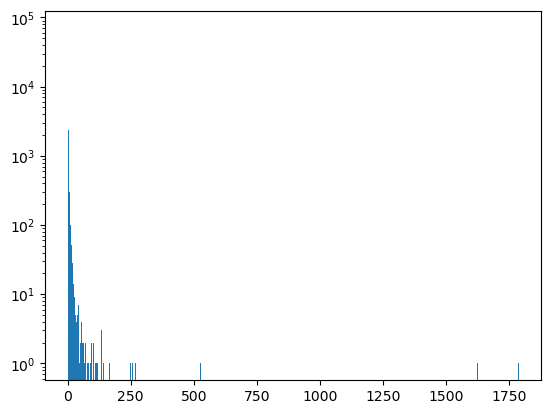

In [92]:
plt.hist(in_degree, bins = np.arange(np.min(in_degree), np.max(in_degree)+2))
plt.yscale('log')
plt.show()

In [73]:
dict_in_degree = dict(g.in_degree(g.nodes))
print("Top most in-degree connected users: ,", sorted(dict_in_degree, key=dict_in_degree.get, reverse=True)[:20])
dict_out_degree = dict(g.out_degree(g.nodes))
print("Top most out-degree connected users: ,", sorted(dict_out_degree, key=dict_out_degree.get, reverse=True)[:10])

Top most in-degree connected users: , ['UKChange', 'BorisJohnson', 'piersmorgan', 'YouTube', 'MattHancock', 'realDonaldTrump', 'SkyNews', 'BBCNews', 'WHO', 'NHSuk', 'PHE_uk', 'afneil', 'guardian', '10DowningStreet', 'GMB', 'MailOnline', 'DHSCgovuk', 'RishiSunak', 'Peston', 'NicolaSturgeon']
Top most out-degree connected users: , ['ChrisWithTheBat', 'mzochealthcare', 'TheBusJourney', 'Ilona_Johnson', 'Stan_Ferguson', 'heathertheminx', 'travelmadeleine', 'DylanClarkMoore', 'Policy_Connect', 'enoreV__']


# Tweets analysis

Tokenize the tweets:

In [96]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+') 

def tokenize_tweet(tweet):
    
    word_tokens = tokenizer.tokenize(tweet)
    filtered_sentence = [w.lower() for w in word_tokens if not w.lower() in stop_words]
    return filtered_sentence


In [97]:
data_df['tokens'] = data_df['tweet'].apply(tokenize_tweet)


In [100]:
data_df['word_count'] = data_df['tokens'].apply((Counter))

In [101]:
data_df['tweet_timestamp'] = pd.to_datetime(data_df['tweet_timestamp'], format='%Y-%m-%d %H:%M:%S')

In [104]:
def merge_dicts(x):
    return {k: v for d in x.dropna() for k, v in d.items()}

word_count_weekly = data_df.groupby(pd.Grouper(key='tweet_timestamp', axis=0, freq='7D', sort=True))['word_count'].sum()

KeyboardInterrupt: 

# Identify communities

In [ ]:
partition = community.best_partition(g)

In [ ]:
communities = np.unique(list(partition.values()))